[View in Colaboratory](https://colab.research.google.com/github/gte620v/PracticalDataScience/blob/master/exercises/solutions/Ex10_Keras_Digits_solution.ipynb)

In [0]:
%matplotlib inline


from IPython.display import Audio, display
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, minmax_scale

plt.rcParams['figure.figsize'] = (15.0, 3.0)

In [88]:
!pip install pydot
!apt-get install -yq graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [90]:
(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()
X = np.vstack([x_train_,x_test_])[...,np.newaxis]
y_ = np.hstack([y_train_,y_test_])
train_ = np.hstack([y_train_*0+1,0*y_test_])
label_coder = LabelBinarizer()

label_coder.fit(y_)

Y = label_coder.transform(y_)
X.shape, Y.shape

((70000, 28, 28, 1), (70000, 10))

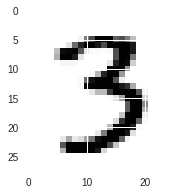

In [91]:
plt.imshow(X[10000,...,0])

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

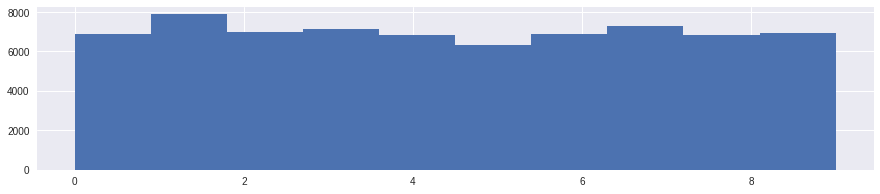

In [92]:
plt.hist(y_)

In [96]:
input_ = Input((28,28,1))

x = Conv2D(32, (3,3), activation='relu')(input_)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(100,activation='relu')(x)


# x2 = Flatten()(x)
# x2 = BatchNormalization()(x2)
# x2 = Dense(100,activation='relu')(x2)

# x = Concatenate()([x1,x2])

x = Dense(10, activation='softmax')(x)



model = Model(input_, x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 9216)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 9216)              36864     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               921700    
__________

In [85]:
new_model = Model(input_,model.layers[-2].output)

new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 26, 26, 32)   320         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 24, 24, 64)   18496       conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 12, 12, 64)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
flatten_16

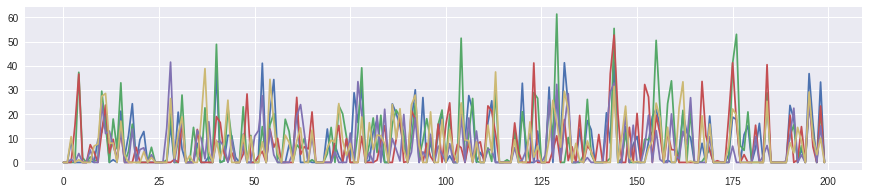

In [94]:
activations = K.eval(new_model(K.variable(X[:5,...])))

plt.plot(activations.T)

In [63]:
kerns = K.eval(model.layers[1].weights[0])
kerns.shape

(3, 3, 1, 32)

In [0]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
nrow = 8; ncol = 4;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

k = 0
for ax in axs.reshape(-1): 
    ax.imshow(kerns[:,:,0,k])
    k += 1

In [0]:
for k in range(32):
    plt.imshow(kerns[:,:,0,k])
    plt.show()

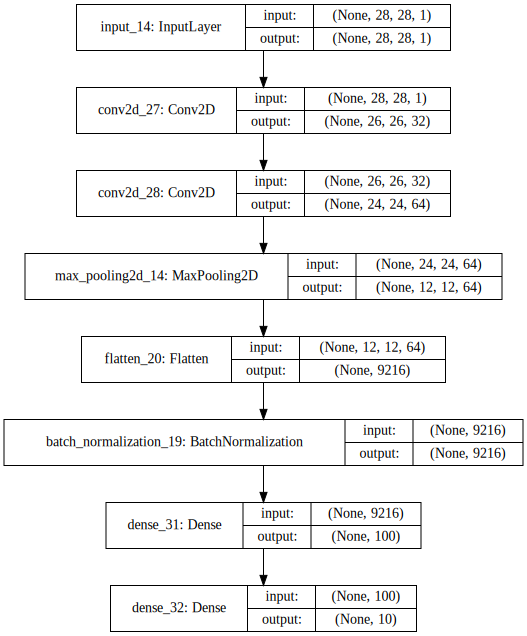

In [97]:
SVG(model_to_dot(model,True,True).create(prog='dot', format='svg'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=.001),metrics=['accuracy'])

In [99]:
def lrs(epoch):
    print(f'epoch = {epoch}')
    lr = 0.01**(1+epoch/2)
    print(f'lr = {lr}')
    return lr

calls = [LearningRateScheduler(lrs)]

model.fit(X,Y, batch_size=400, epochs=4, callbacks=calls)

Epoch 1/4
epoch = 0
lr = 0.01
70000/70000 [==============================] - 9s 135us/step - loss: 0.7548 - acc: 0.9353
Epoch 2/4
epoch = 1
lr = 0.001
70000/70000 [==============================] - 7s 107us/step - loss: 0.3244 - acc: 0.9750
Epoch 3/4
epoch = 2
lr = 0.0001
70000/70000 [==============================] - 8s 108us/step - loss: 0.2185 - acc: 0.9831
Epoch 4/4
epoch = 3
lr = 1e-05
61200/70000 [=========================>....] - ETA: 0s - loss: 0.2081 - acc: 0.9836

70000/70000 [==============================] - 8s 108us/step - loss: 0.2073 - acc: 0.9837


In [100]:
y_hat = model.predict(X,batch_size=400, verbose=1)

70000/70000 [==============================] - 3s 43us/step


In [0]:
from sklearn.metrics import confusion_matrix
import itertools
plt.rcParams['figure.figsize'] = (15.0, 15.0)
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred,)
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(y_, label_coder.inverse_transform(y_hat), label_coder.classes_);

In [104]:
(.91060 - .90825)/.91060*100

0.2580716011421001